# Darknet
=> GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


# Tracking

In [ ]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [ ]:
min_confidence = 0.5
weight_file = '/content/drive/MyDrive/darknet/yolov3.weights'
cfg_file = '/content/drive/MyDrive/darknet/cfg/yolov3.cfg'
name_file = '/content/drive/MyDrive/darknet/data/coco.names'
file_name = '/content/drive/MyDrive/Fastcampus_OpenCV/cabc30fc-e7726578.mp4'

In [ ]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

classes = []
with open(name_file, "r") as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
layer_names = net.getLayerNames()
output_layers_indices = net.getUnconnectedOutLayers()
output_layers = [layer_names[i - 1] for i in output_layers_indices]

In [ ]:
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

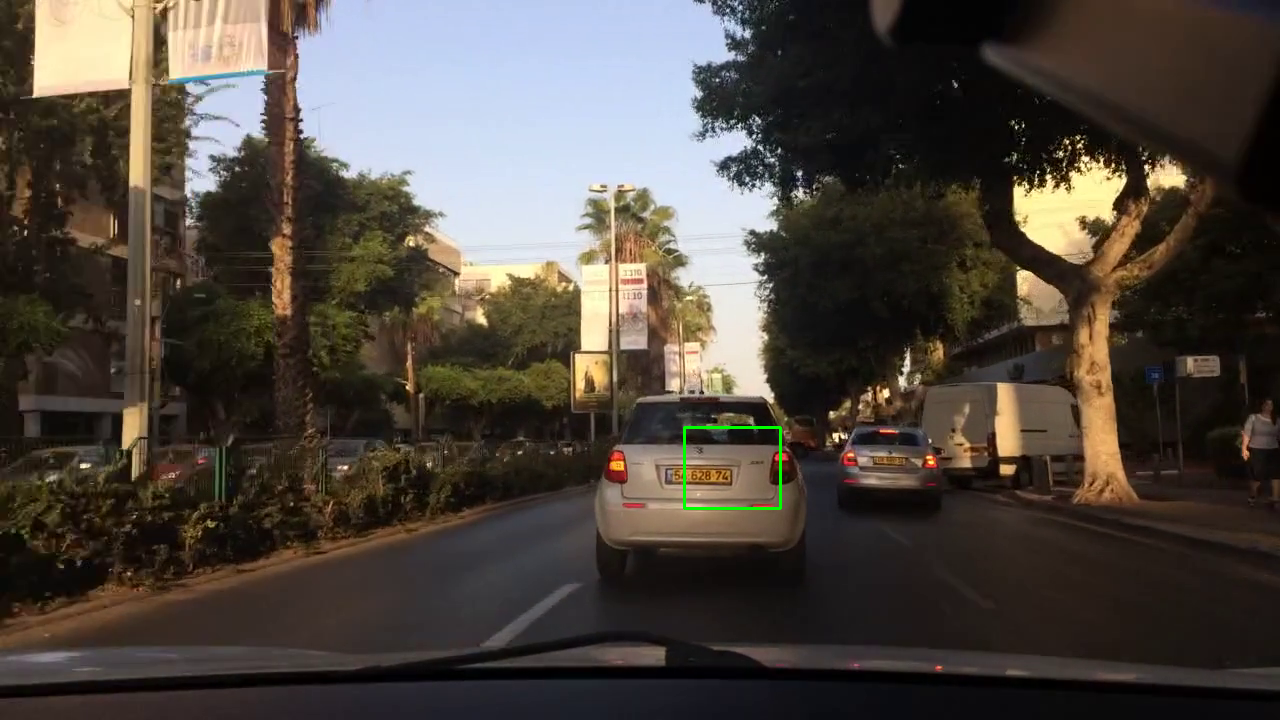

[Tracking] Frame 1097 time 0.4379763603210449


In [ ]:
frame_count = 0
# initialize the video writer
writer = None
output_name = 'output_tracking.avi'

detected = False
frame_mode = 'Tracking'
elapsed_time = 0
tracker = cv2.legacy.TrackerMOSSE_create()
trackers = cv2.legacy.MultiTracker_create()
vs = cv2.VideoCapture(file_name)

while True:
    start_time = time.time()
    frame_count += 1
    ret, frame = vs.read()
    if frame is None:
        print('### No more frame ###')
        break
    IPython.display.clear_output(wait=True)
    if detected:
        frame_mode = 'Tracking'
        (success, boxes) = trackers.update(frame)
        for box in boxes:
           (x, y, w, h) = [int(v) for v in box]
           cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    else:
        frame_mode = 'Detection'
        height, width, channedls = frame.shape
        # Detecting objects
        # https://docs.opencv.org/master/d6/d0f/group__dnn.html
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        # Region of Interest
        roi_left = int(0.3 * width)
        roi_right = int(0.6 * width)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
        font = cv2.FONT_HERSHEY_COMPLEX
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                # Eliminate Small object(<50)
                if (w > 50) and (x > roi_left) and (x < roi_right):
                    selected = boxes[i]
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 5)
        trackers.add(tracker, frame, tuple(selected))
        detected = True

    cv2_imshow(frame)
    writeFrame(frame)
    frame_time = time.time() - start_time
    elapsed_time += frame_time
    print("[{}] Frame {} time {}".format(frame_mode, frame_count, frame_time))

print("Elapsed time {}".format(elapsed_time))
vs.release()

In [ ]:
from google.colab import files
files.download(output_name)